In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import data_reader as dr
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,mean_absolute_error
from tensorflow import keras

In [2]:
data, target = dr.read_data(window=22)
split_index = int(len(data)*0.8)
data.info()
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2406 entries, 0 to 2405
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 2406 non-null   object 
 1   Daily_trading_range  2406 non-null   float64
 2   Log_Volume_change    2406 non-null   float64
 3   Daily_return         2406 non-null   float64
 4   Daily_log_return     2406 non-null   float64
 5   Index                2406 non-null   float64
 6   oil                  2406 non-null   float64
dtypes: float64(6), object(1)
memory usage: 131.7+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2384 entries, 0 to 2383
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Target  2384 non-null   float64
dtypes: float64(1)
memory usage: 37.2 KB


In [3]:
def data_prep(data, target, split_index, n_ahead=1, window=22):


    data = data.drop(['Daily_return','Date'], axis=1)

    window = window
    n_ahead = n_ahead
    y_values = target
    x_values = data
    print(x_values.info())

    scaler = MinMaxScaler()
    scaled_x = scaler.fit_transform(x_values)
    scaled_y = scaler.fit_transform(y_values)

    trainX = np.array(scaled_x[:split_index])
    testX = np.array(scaled_x[split_index:])
    trainY = np.array(scaled_y[:split_index])
    testY = np.array(scaled_y[split_index:])

    Xtrain = np.array([])
    ytrain = np.array([])
    Xtest = np.array([])
    ytest = np.array([])

    for i in range(window, len(trainX)-n_ahead-window):
        candidate = trainX[i - window:i, :trainX.shape[1]]

        candidate = candidate.reshape(1, candidate.shape[0], candidate.shape[1])
        y_candidate = trainY[i-window:i-window+n_ahead].reshape(1, trainY[i-window:i-window+n_ahead].shape[0], trainY[i:i+n_ahead].shape[1])

        if i==window:
            Xtrain = candidate
            ytrain = y_candidate
            continue

        Xtrain = np.append(Xtrain, candidate, axis=0)
        ytrain = np.append(ytrain, y_candidate, axis=0)
        # ytrain.append(trainY[i:i+n_ahead])

    for i in range(window, len(testX)-n_ahead-window):
        test_candidate = testX[i - window:i, :testX.shape[1]]
        test_candidate = test_candidate.reshape(1, test_candidate.shape[0], test_candidate.shape[1])
        test_y_can = testY[i-window:i-window+n_ahead].reshape(1, testY[i-window:i-window+n_ahead].shape[0], testY[i-window:i-window+n_ahead].shape[1])

        if(i==window):
            Xtest = test_candidate
            ytest = test_y_can
            continue
        Xtest = np.append(Xtest, test_candidate, axis=0)
        ytest = np.append(ytest, test_y_can, axis=0)

        # Xtest.append(test_candidate)
        # ytest.append(testY[i:i+n_ahead])
    # Xtrain, ytrain = (np.array(Xtrain), np.array(ytrain))
    # Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], Xtrain.shape[1], Xtrain.shape[2]))
    #
    # Xtest, ytest = (np.array(Xtest), np.array(ytest))
    # Xtest = np.reshape(Xtest, (Xtest.shape[0], Xtest.shape[1], Xtest.shape[2]))

    print(Xtrain.shape)
    print(ytrain.shape)
    print("-----")
    print(Xtest.shape)
    print(ytest.shape)
    return Xtrain, ytrain, Xtest, ytest, scaler


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2406 entries, 0 to 2405
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 2406 non-null   object 
 1   Daily_trading_range  2406 non-null   float64
 2   Log_Volume_change    2406 non-null   float64
 3   Daily_return         2406 non-null   float64
 4   Daily_log_return     2406 non-null   float64
 5   Index                2406 non-null   float64
 6   oil                  2406 non-null   float64
dtypes: float64(6), object(1)
memory usage: 131.7+ KB


In [5]:
Xtrain, ytrain, Xtest, ytest, scaler = data_prep(data, target, split_index=split_index, window=22, n_ahead=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2406 entries, 0 to 2405
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Daily_trading_range  2406 non-null   float64
 1   Log_Volume_change    2406 non-null   float64
 2   Daily_log_return     2406 non-null   float64
 3   Index                2406 non-null   float64
 4   oil                  2406 non-null   float64
dtypes: float64(5)
memory usage: 94.1 KB
None
(1879, 22, 5)
(1879, 1, 1)
-----
(437, 22, 5)
(437, 1, 1)


In [6]:
print(Xtrain.shape)
print(ytrain.shape)
print("-----")
print(Xtest.shape)
print(ytest.shape)

(1879, 22, 5)
(1879, 1, 1)
-----
(437, 22, 5)
(437, 1, 1)


In [90]:
def create_model(neurons1=10, neurons2=10, neurons3=10, lr=0.001, activation='tanh'):
    model = Sequential()
    model.add(Flatten(input_shape=(Xtrain.shape[1],Xtrain.shape[2])))
    model.add(Dense(neurons1,activation=activation))
    model.add(Dropout(0.3))
    model.add(Dense(neurons2,activation=activation))
    model.add(Dropout(0.3))
    model.add(Dense(neurons3,activation=activation))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    adam = Adam(learning_rate=lr)
    model.compile(loss='mse', optimizer=adam)
    return model
    # model.fit(Xtrain, ytrain, epochs=150, batch_size=16, validation_split=0.1, shuffle=False)

In [8]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier


In [9]:
regressor = KerasRegressor(build_fn=create_model, epochs=50, batch_size=16, verbose=0)

In [10]:
tscv = TimeSeriesSplit(n_splits=3)



In [11]:
params = dict(neurons1=[64,32,16,10,5],
              neurons2=[64,32,16,10,5],
              neurons3=[64,32,16,10,5],
              batch_size=[32,16],
              lr=[0.001,0.005,0.0005],
              activation=['tanh','relu'],
              epochs=[50,100]
              )
grid = GridSearchCV(estimator=regressor, param_grid=params, verbose=10, cv=tscv)
grid_result = grid.fit(Xtrain, ytrain)

Fitting 3 folds for each of 3000 candidates, totalling 9000 fits
[CV 1/3; 1/3000] START activation=tanh, batch_size=32, epochs=50, lr=0.001, neurons1=64, neurons2=64, neurons3=64
[CV 1/3; 1/3000] END activation=tanh, batch_size=32, epochs=50, lr=0.001, neurons1=64, neurons2=64, neurons3=64; total time=   2.2s
[CV 2/3; 1/3000] START activation=tanh, batch_size=32, epochs=50, lr=0.001, neurons1=64, neurons2=64, neurons3=64
[CV 2/3; 1/3000] END activation=tanh, batch_size=32, epochs=50, lr=0.001, neurons1=64, neurons2=64, neurons3=64; total time=   2.4s
[CV 3/3; 1/3000] START activation=tanh, batch_size=32, epochs=50, lr=0.001, neurons1=64, neurons2=64, neurons3=64
[CV 3/3; 1/3000] END activation=tanh, batch_size=32, epochs=50, lr=0.001, neurons1=64, neurons2=64, neurons3=64; total time=   3.3s
[CV 1/3; 2/3000] START activation=tanh, batch_size=32, epochs=50, lr=0.001, neurons1=64, neurons2=64, neurons3=32
[CV 1/3; 2/3000] END activation=tanh, batch_size=32, epochs=50, lr=0.001, neurons1=

In [12]:
print('Best score s: {} using {}'.format(grid_result.best_score_, grid_result.best_params_))
bestParams = grid_result.best_params_

Best score s: -0.0013486331057113905 using {'activation': 'tanh', 'batch_size': 16, 'epochs': 100, 'lr': 0.005, 'neurons1': 64, 'neurons2': 64, 'neurons3': 16}


## Gridsearch result (ANN)
activation: tanh
batch_size: 16
epochs: 100
learning rate: 0.001,
neuron1 64
neuron2 64
neuron3 16

In [101]:
model = create_model(neurons1=64,neurons2=64, neurons3=16, lr=0.005)
model_fit = model.fit(Xtrain, ytrain, batch_size=32, epochs=100)
forecast = model.predict(Xtest)

Epoch 1/100
59/59 [==============================] - 1s 2ms/step - loss: 0.8646
Epoch 2/100
59/59 [==============================] - 0s 2ms/step - loss: 0.1343
Epoch 3/100
59/59 [==============================] - 0s 2ms/step - loss: 0.0544
Epoch 4/100
59/59 [==============================] - 0s 1ms/step - loss: 0.0288
E

In [102]:
forecast = forecast.mean(axis=1).reshape(len(forecast),1)
ytest = ytest.mean(axis=1).reshape(len(ytest),1)

print(forecast.shape)
print(ytest.shape)

(437, 1)
(437, 1)


In [103]:
rev_forecast = scaler.inverse_transform(forecast)
rev_ytest = scaler.inverse_transform(ytest)

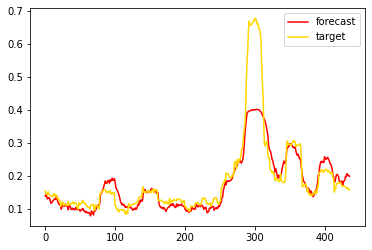

In [104]:
plt.plot(rev_forecast, color='red', label='forecast')
plt.plot(rev_ytest, color='gold', label='target')
plt.legend()
# plt.savefig("images/single_layer_model_pred.png")

plt.show()

In [105]:
testScore = mean_squared_error(y_true=rev_ytest, y_pred=rev_forecast)
print("test Score: {score} MSE".format(score=testScore))
root_testScore = mean_squared_error(y_true=rev_ytest, y_pred=rev_forecast, squared=False)
print("test Score: {score} RMSE".format(score=root_testScore))
mape = mean_absolute_percentage_error(y_pred=rev_forecast, y_true=rev_ytest)
print("test Score: {score} MAPE".format(score=mape))
mae = mean_absolute_error(y_pred=rev_forecast, y_true=rev_ytest)
print("test Score: {score} MAE".format(score=mae))

test Score: 0.0036858780030398757 MSE
test Score: 0.06071143222688685 RMSE
test Score: 0.13577848664284525 MAPE
test Score: 0.030754939842258265 MAE


In [ ]:
model.save